In [44]:
import sys
sys.path.append('../code')
from resnet import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
from numpy import polyfit
from numpy import polyval
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from scipy.interpolate import interp1d
%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [45]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого
_, test_loader, train_loader_no_augumentation, valid_loader = cifar10_loader(batch_size=128, split_train_val=True,
                                                                             maxsize=10112*2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch_num = 200
# epoch_num = 50
run_num = 5 # количество запусков эксперимента
# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '17' 

validate_every_epoch = 5 
# spline_mode = 'linear' #полиномом какой степени пользуемся, смотри функцию scipy.interpolate.interp1d
# spline_mode = 'quadratic'
# spline_mode = 'cubic'
# train_splines_every_epoch = 5 # каждые 5 эпох отслеживать траекторию гиперпараметров
train_splines_every_epoch = 2
# train_splines_every_epoch = 3
# train_splines_every_epoch = 10
epoch_size = 10
# размер мини-эпохи в батчах, за которую у нас производится либо обучение спайлов, либо их использование
mini_epoch_size = 10 

In [47]:
def accuracy(student):
        student.eval()
        total = 0 
        correct = 0
        with t.no_grad():
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = student(x)
                correct += t.eq(t.argmax(out, 1), y).sum()
                total+=len(x)
        student.train()
        return (correct/total).cpu().detach().numpy()

In [48]:
kl = nn.KLDivLoss(reduction='batchmean')
sm = nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = F.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [ ]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-beta
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss
# определяем функцию валидационную функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

logits = np.load('../code/logits_cnn.npy')
for _ in range(run_num):
    internal_results = []    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0), device=device), requires_grad=True)    
    h = [beta1, beta2, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
    # параметры Adam и функцию подсчета градиента 
    # взял из статьи по DARTS (выбор архитектуры сети градиентными методами)
    # там также используется оптимизация гиперпараметров
    optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    
    crit = t.nn.CrossEntropyLoss()

    for e in range(epoch_num): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        
        
        tq = tqdm.tqdm(zip(train_loader_no_augumentation, valid_loader))
        losses = []
        for batch_id, ((x,y), (v_x, v_y)) in enumerate(tq):
            mini_e = batch_id // mini_epoch_size
            
            if mini_e % train_splines_every_epoch == 0 and batch_id % mini_epoch_size  == 0:                
                spline_hist = []
                spline_id  = -1 
                #print (batch_id, 'start mini')

            spline_id += 1
            x = x.to(device)
            y = y.to(device)            
                      
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            # если настала пора понаблюдать за траекторий гиперпараметров
            if mini_e % train_splines_every_epoch == 0:
                #print (batch_id, 'train mini')
                v_x = v_x.to(device)
                v_y = v_y.to(device)  
                optim2.zero_grad()            
                hyper_grad_calc.calc_gradients((x,y,batch_logits), (v_x, v_y))            
                optim2.step()                
                spline_hist.append([h_.grad.cpu().detach().clone().numpy()  for h_ in h])
            else:
                #print (batch_id, 'infer mini')
                spline_out = splines(spline_id)
                optim2.zero_grad()            
                beta1.grad.data += spline_out[0]
                beta2.grad.data += spline_out[1]
                temp.grad.data += spline_out[2]
                optim2.step() 
                    
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        
        # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
            if mini_e % train_splines_every_epoch == 0 and batch_id%mini_epoch_size == mini_epoch_size-1:
                fitted1 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,0], 1)
                fitted2 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,1], 1)
                fitted3 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,2], 1)
                splines = lambda x : np.array([np.polyval(fitted1, x), np.polyval(fitted2, x), np.polyval(fitted3, x)])

        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            test_loss2 = []            
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss2.append(crit(student(x), y).detach().cpu().numpy())                 
            print (float(np.mean(test_loss2)))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 
                                     'temp':float(10*F.sigmoid(h[2]).cpu().detach().numpy()),
                                     'beta1':float(F.sigmoid(h[0]).cpu().detach().numpy()),
                                     'beta2':float(F.sigmoid(h[1]).cpu().detach().numpy())})
            
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_dist_h_b2_optim.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

0it [00:00, ?it/s]<ipython-input-48-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:1.0550315380096436: : 79it [00:03, 20.20it/s]


1.6469966173171997


current loss:0.9994255900382996: : 2it [00:00, 18.48it/s]

{'epoch': 0, 'test loss': 1.6399352550506592, 'accuracy': 0.398499995470047, 'temp': 5.7102906703948975, 'beta1': 0.5232616066932678, 'beta2': 0.4670736789703369}


current loss:0.9396446347236633: : 79it [00:03, 20.46it/s]
current loss:0.8743222951889038: : 79it [00:03, 20.25it/s]
current loss:0.8325732946395874: : 79it [00:03, 20.08it/s]
current loss:0.8009086847305298: : 79it [00:04, 19.47it/s]


1.3711891174316406


current loss:0.7368790507316589: : 2it [00:00, 17.49it/s]

{'epoch': 4, 'test loss': 1.3733348846435547, 'accuracy': 0.5105000138282776, 'temp': 5.678123235702515, 'beta1': 0.5252096056938171, 'beta2': 0.48926690220832825}


current loss:0.7771590352058411: : 79it [00:04, 19.65it/s]
current loss:0.7579801082611084: : 79it [00:03, 19.91it/s]
current loss:0.7411041259765625: : 79it [00:03, 19.99it/s]
current loss:0.7249501943588257: : 79it [00:03, 19.99it/s]
current loss:0.71507728099823: : 79it [00:03, 20.28it/s]  


1.433406949043274


current loss:0.6315553784370422: : 2it [00:00, 18.75it/s]

{'epoch': 9, 'test loss': 1.430631399154663, 'accuracy': 0.5141000151634216, 'temp': 5.636604428291321, 'beta1': 0.5276780724525452, 'beta2': 0.5171658396720886}


current loss:0.705689549446106: : 79it [00:03, 20.56it/s] 
current loss:0.6940079927444458: : 79it [00:03, 20.39it/s]
current loss:0.6873279213905334: : 79it [00:03, 20.39it/s]
current loss:0.6801396012306213: : 79it [00:03, 20.56it/s]
current loss:0.6676785945892334: : 79it [00:03, 20.42it/s]


1.5622327327728271


current loss:0.5682416558265686: : 2it [00:00, 17.94it/s]

{'epoch': 14, 'test loss': 1.5712552070617676, 'accuracy': 0.50409996509552, 'temp': 5.557696223258972, 'beta1': 0.5319456458091736, 'beta2': 0.5410043001174927}


current loss:0.6535731554031372: : 79it [00:03, 20.03it/s]
current loss:0.6400593519210815: : 79it [00:03, 20.19it/s]
current loss:0.6366663575172424: : 79it [00:03, 20.68it/s]
current loss:0.6318120956420898: : 79it [00:03, 20.70it/s]
current loss:0.6302146315574646: : 79it [00:03, 19.94it/s]


1.848767638206482


current loss:0.5326314568519592: : 2it [00:00, 18.45it/s]

{'epoch': 19, 'test loss': 1.8309990167617798, 'accuracy': 0.4837999939918518, 'temp': 5.510628819465637, 'beta1': 0.5345355868339539, 'beta2': 0.5516706705093384}


current loss:0.6263508200645447: : 79it [00:03, 20.85it/s]
current loss:0.6311233043670654: : 79it [00:03, 20.89it/s]
current loss:0.6225689649581909: : 79it [00:03, 20.85it/s]
current loss:0.6150317192077637: : 79it [00:03, 20.64it/s]
current loss:0.6103673577308655: : 79it [00:03, 20.39it/s]


1.7475022077560425


current loss:0.49624255299568176: : 2it [00:00, 18.73it/s]

{'epoch': 24, 'test loss': 1.7531479597091675, 'accuracy': 0.513700008392334, 'temp': 5.3622424602508545, 'beta1': 0.5417208075523376, 'beta2': 0.5773887038230896}


current loss:0.6062853336334229: : 79it [00:03, 20.96it/s]
current loss:0.6027253866195679: : 79it [00:03, 20.87it/s]
current loss:0.5995879769325256: : 79it [00:03, 20.96it/s]
current loss:0.5959641337394714: : 79it [00:03, 20.63it/s]
current loss:0.5919672250747681: : 79it [00:03, 20.09it/s]


1.7653839588165283


current loss:0.4704238176345825: : 2it [00:00, 18.26it/s]

{'epoch': 29, 'test loss': 1.7640697956085205, 'accuracy': 0.5210999846458435, 'temp': 5.182547569274902, 'beta1': 0.5501856207847595, 'beta2': 0.5946254134178162}


current loss:0.5874382853507996: : 79it [00:03, 20.75it/s]
current loss:0.5839132070541382: : 79it [00:03, 20.55it/s]
current loss:0.5807685256004333: : 79it [00:03, 20.32it/s]
current loss:0.5759361386299133: : 79it [00:03, 20.03it/s]
current loss:0.5726373195648193: : 79it [00:03, 19.98it/s]


1.8119609355926514


current loss:0.45886874198913574: : 2it [00:00, 18.10it/s]

{'epoch': 34, 'test loss': 1.806455373764038, 'accuracy': 0.5260999798774719, 'temp': 5.026487112045288, 'beta1': 0.5571845769882202, 'beta2': 0.606895923614502}


current loss:0.5669973492622375: : 79it [00:03, 20.31it/s]
current loss:0.5652217864990234: : 79it [00:03, 20.21it/s]
current loss:0.5606918334960938: : 79it [00:03, 20.27it/s]
current loss:0.5548959970474243: : 79it [00:03, 20.32it/s]
current loss:0.5549320578575134: : 79it [00:03, 20.18it/s]


1.9469057321548462


current loss:0.4569030702114105: : 2it [00:00, 18.07it/s] 

{'epoch': 39, 'test loss': 1.954459309577942, 'accuracy': 0.5167999863624573, 'temp': 4.912195801734924, 'beta1': 0.5621908903121948, 'beta2': 0.6127511858940125}


current loss:0.5592660307884216: : 79it [00:03, 20.18it/s]
current loss:0.5667292475700378: : 79it [00:03, 20.32it/s]
current loss:0.568639874458313: : 79it [00:03, 19.97it/s] 
current loss:0.5696845650672913: : 79it [00:03, 20.08it/s] 
current loss:0.5652639269828796: : 79it [00:03, 20.40it/s] 


2.0736048221588135


current loss:0.47681936621665955: : 2it [00:00, 18.35it/s]

{'epoch': 44, 'test loss': 2.0748000144958496, 'accuracy': 0.5120999813079834, 'temp': 4.839133024215698, 'beta1': 0.5654682517051697, 'beta2': 0.6160914301872253}


current loss:0.5590155720710754: : 79it [00:03, 20.14it/s]
current loss:0.5631016492843628: : 79it [00:03, 20.36it/s]
current loss:0.5651947259902954: : 79it [00:03, 20.41it/s]
current loss:0.5540251731872559: : 79it [00:03, 20.64it/s]
current loss:0.5447171926498413: : 79it [00:03, 20.45it/s]


2.1439266204833984


current loss:0.4301396310329437: : 2it [00:00, 18.49it/s]

{'epoch': 49, 'test loss': 2.1559832096099854, 'accuracy': 0.5110999941825867, 'temp': 4.732879102230072, 'beta1': 0.5700573325157166, 'beta2': 0.6293408870697021}


current loss:0.5344597697257996: : 79it [00:03, 20.28it/s] 
current loss:0.5308336019515991: : 79it [00:03, 20.04it/s] 
current loss:0.525576114654541: : 79it [00:03, 19.98it/s]  
current loss:0.5208088159561157: : 79it [00:03, 19.95it/s] 
current loss:0.5143824815750122: : 79it [00:03, 20.35it/s] 


2.1661946773529053


current loss:0.40401092171669006: : 2it [00:00, 18.43it/s]

{'epoch': 54, 'test loss': 2.1935718059539795, 'accuracy': 0.5173999667167664, 'temp': 4.596123695373535, 'beta1': 0.5757454633712769, 'beta2': 0.643006443977356}


current loss:0.5119863748550415: : 79it [00:03, 20.19it/s] 
current loss:0.5023685693740845: : 79it [00:03, 20.37it/s] 
current loss:0.49460411071777344: : 79it [00:03, 20.50it/s]
current loss:0.4920555055141449: : 79it [00:03, 20.61it/s] 
current loss:0.4857395589351654: : 79it [00:03, 20.32it/s] 


2.2422468662261963


current loss:0.38731148838996887: : 2it [00:00, 16.99it/s]

{'epoch': 59, 'test loss': 2.2472996711730957, 'accuracy': 0.5246999859809875, 'temp': 4.475288093090057, 'beta1': 0.5807564854621887, 'beta2': 0.6528105735778809}


current loss:0.48049354553222656: : 79it [00:04, 19.50it/s]
current loss:0.4782547950744629: : 79it [00:04, 19.63it/s] 
current loss:0.47007322311401367: : 79it [00:03, 20.59it/s]

In [6]:
data_b = []
data_d = []
data_h = []
with open("../code/exp6_basic.jsonl", "r") as read_file:
    data_b = [json.loads(line) for line in read_file]
with open("../code/exp6_distill.jsonl", "r") as read_file:
    data_d = [json.loads(line) for line in read_file]
with open("exp17_dist_h_rand.jsonl", "r") as read_file:
    data_dr = [json.loads(line) for line in read_file]
with open("exp17_dist_h_optim.jsonl", "r") as read_file:
    data_h = [json.loads(line) for line in read_file]
with open("exp17_dist_h_b2_optim.jsonl", "r") as read_file:
    data_s = [json.loads(line) for line in read_file]    

In [7]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

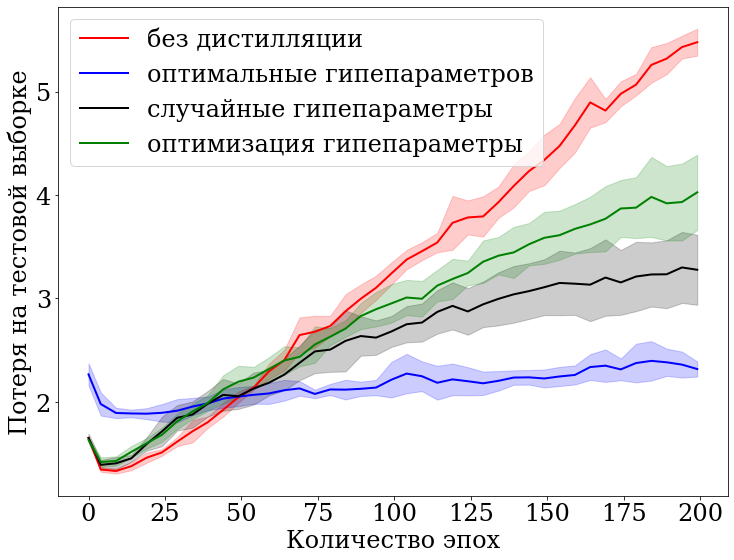

In [47]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, loss_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, loss_d.mean(1), '-', color='blue', label='оптимальные гипепараметров')
plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, loss_dr.mean(1), '-', color='black', label='случайные гипепараметры')
plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, loss_h.mean(1), '-', color='green', label='оптимизация гипепараметры')
plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('loss_10.pdf')

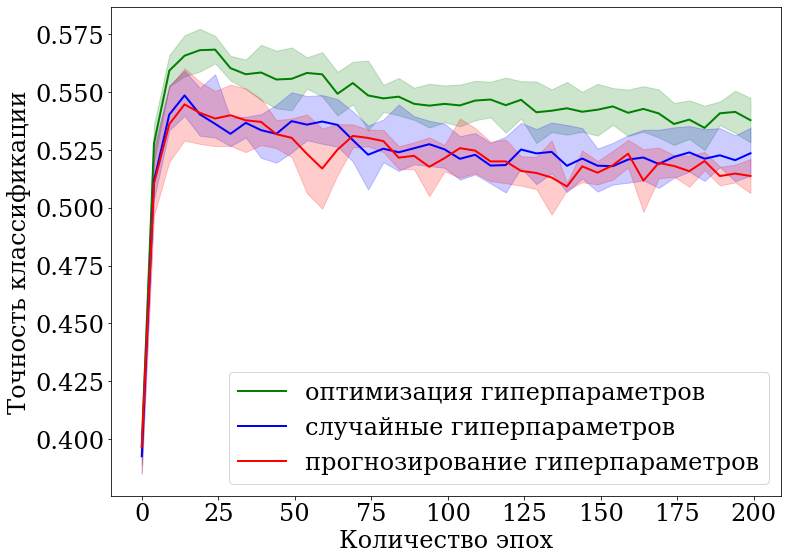

In [17]:
# epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
# acc_b = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
# plt.plot(epoch_b, acc_b.mean(1), '-', color='red', label='без дистилляции')
# plt.fill_between(epoch_b, acc_b.mean(1)-acc_b.std(1), acc_b.mean(1)+acc_b.std(1), alpha=0.2, color='red')

# epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
# acc_d = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
# plt.plot(epoch_d, acc_d.mean(1), '-', color='blue', label='оптимальные гипепараметры')
# plt.fill_between(epoch_d, acc_d.mean(1)-acc_d.std(1), acc_d.mean(1)+acc_d.std(1), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, acc_h.mean(1), '-', color='green', label='оптимизация гиперпараметров')
plt.fill_between(epoch_h, acc_h.mean(1)-acc_h.std(1), acc_h.mean(1)+acc_h.std(1), alpha=0.2, color='green')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_dr, acc_dr.mean(1), '-', color='blue', label='случайные гиперпараметров')
plt.fill_between(epoch_dr, acc_dr.mean(1)-acc_h.std(1), acc_dr.mean(1)+acc_dr.std(1), alpha=0.2, color='blue')

epoch_s = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_s[2]['results']))])
acc_s = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_s[0]['results'])) for subdata in data_s]).reshape(epoch_s.shape[0], -1)
plt.plot(epoch_s, acc_s.mean(1), '-', color='red', label='прогнозирование гиперпараметров')
plt.fill_between(epoch_s, acc_s.mean(1)-acc_s.std(1), acc_s.mean(1)+acc_s.std(1), alpha=0.2, color='red')


plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc_17.pdf')

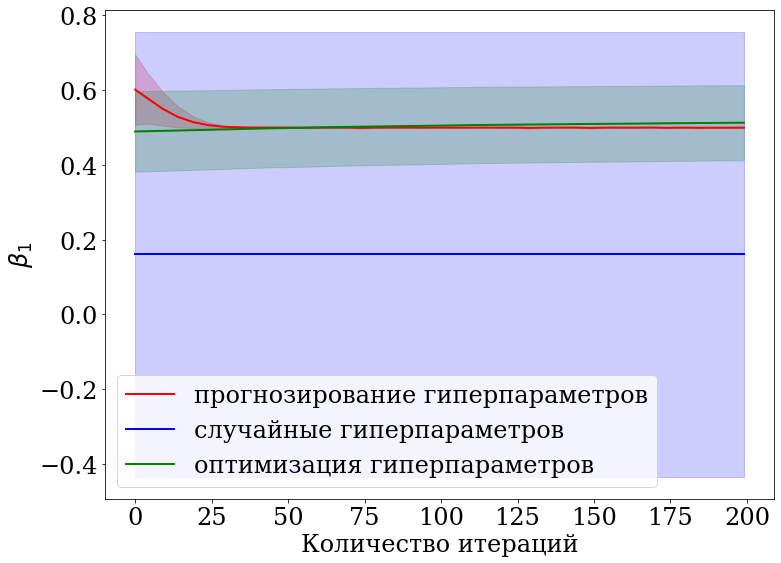

In [14]:
def plot_data_params(data, s, label, color):
    e = np.array([data[2]['results'][i]['epoch'] for i in range(len(data[2]['results']))])
    par = np.array([subdata['results'][i][s] for i in range(len(data[0]['results'])) for subdata in data]).reshape(e.shape[0], -1)
#     par = np.array([data[2]['results'][i][s] for i in range(len(data[2]['results']))])
#     par = []
#     for subdata in data:
#         tmp = [subdata['results'][i][s] for i in range(len(subdata['results']))]
#         par.append(tmp)
#     par = np.array(par).reshape(e.shape[0], -1)
    plt.plot(e, par.mean(1), '-', color=color, label=label)
    plt.fill_between(e, par.mean(1)-par.std(1), par.mean(1)+par.std(1), alpha=0.2, color=color)

plot_data_params(data_s, 'beta1', 'прогнозирование гиперпараметров', 'red')
plot_data_params(data_dr, 'beta1', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'beta1', 'оптимизация гиперпараметров', 'green')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_1$')
# plt.title(r'График зависимости значения $\beta_1$ от номера итерации')
plt.legend()
plt.savefig('beta1_iter2.pdf')
plt.show()

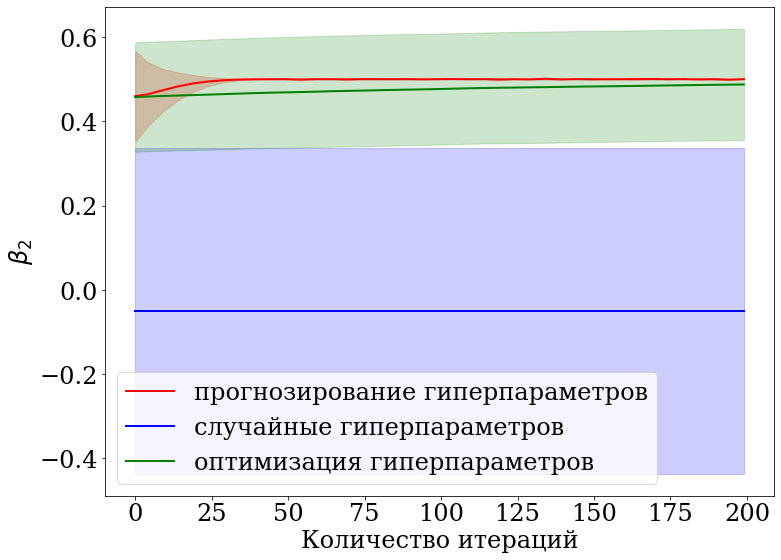

In [15]:
plot_data_params(data_s, 'beta2', 'прогнозирование гиперпараметров', 'red')
plot_data_params(data_dr, 'beta2', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'beta2', 'оптимизация гиперпараметров', 'green')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_2$')
# plt.title(r'График зависимости значения $\beta_2$ от номера итерации')
plt.legend()
plt.savefig('beta2_iter2.pdf')
plt.show()

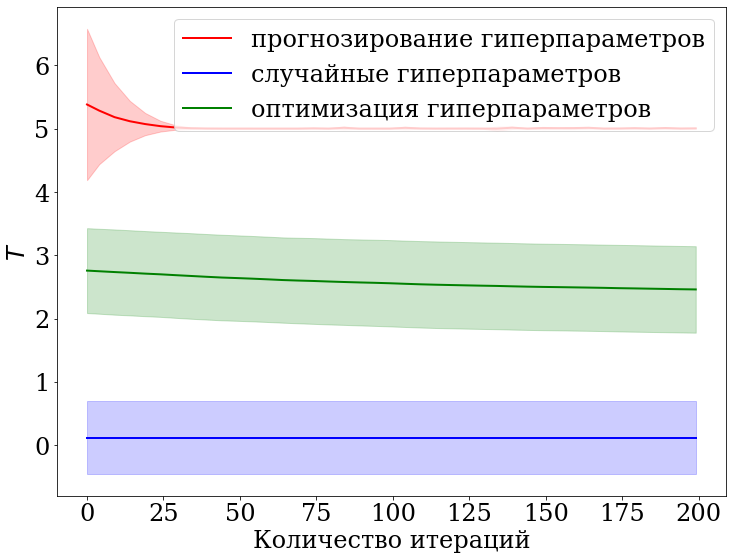

In [16]:
plot_data_params(data_s, 'temp', 'прогнозирование гиперпараметров', 'red')
plot_data_params(data_dr, 'temp', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'temp', 'оптимизация гиперпараметров', 'green')
plt.xlabel('Количество итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('temp_iter2.pdf')
plt.show()

-----------------

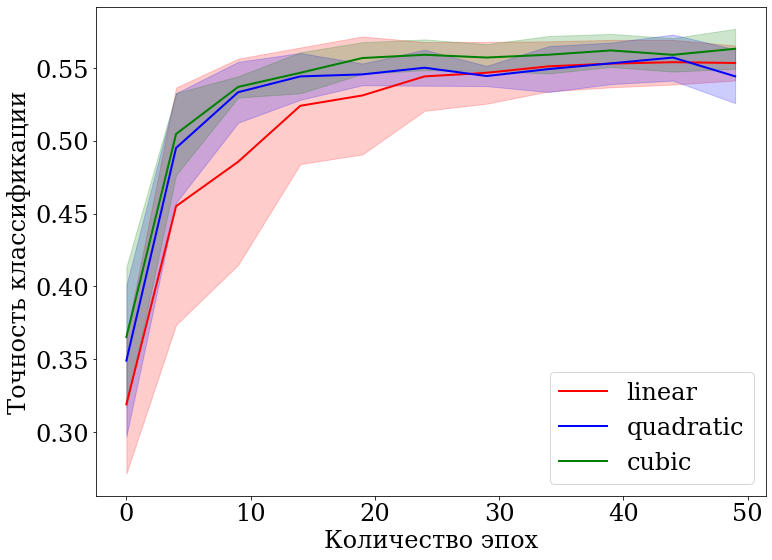

In [53]:
with open("exp8_dist_h_b2_optim.jsonl", "r") as read_file:
    data_l = [json.loads(line) for line in read_file]
with open("exp9_dist_h_b2_optim.jsonl", "r") as read_file:
    data_q = [json.loads(line) for line in read_file]
with open("exp10_dist_h_b2_optim.jsonl", "r") as read_file:
    data_c = [json.loads(line) for line in read_file]

epoch_l = np.array([data_l[2]['results'][i]['epoch'] for i in range(len(data_l[2]['results']))])
acc_l = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_l[0]['results'])) for subdata in data_l]).reshape(epoch_l.shape[0], -1)
plt.plot(epoch_l[0:11], acc_l[0:11].mean(1), '-', color='red', label='linear')
plt.fill_between(epoch_l[0:11], acc_l[0:11].mean(1)-acc_l[0:11].std(1), acc_l[0:11].mean(1)+acc_l[0:11].std(1), alpha=0.2, color='red')

epoch_q = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_q[2]['results']))])
acc_q = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_q[0]['results'])) for subdata in data_q]).reshape(epoch_q.shape[0], -1)
plt.plot(epoch_q, acc_q.mean(1), '-', color='blue', label='quadratic')
plt.fill_between(epoch_q, acc_q.mean(1)-acc_q.std(1), acc_q.mean(1)+acc_q.std(1), alpha=0.2, color='blue')

epoch_c = np.array([data_c[2]['results'][i]['epoch'] for i in range(len(data_c[2]['results']))])
acc_c = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_c[0]['results'])) for subdata in data_c]).reshape(epoch_c.shape[0], -1)
plt.plot(epoch_c, acc_c.mean(1), '-', color='green', label='cubic')
plt.fill_between(epoch_c, acc_c.mean(1)-acc_c.std(1), acc_c.mean(1)+acc_c.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc_splines.pdf')

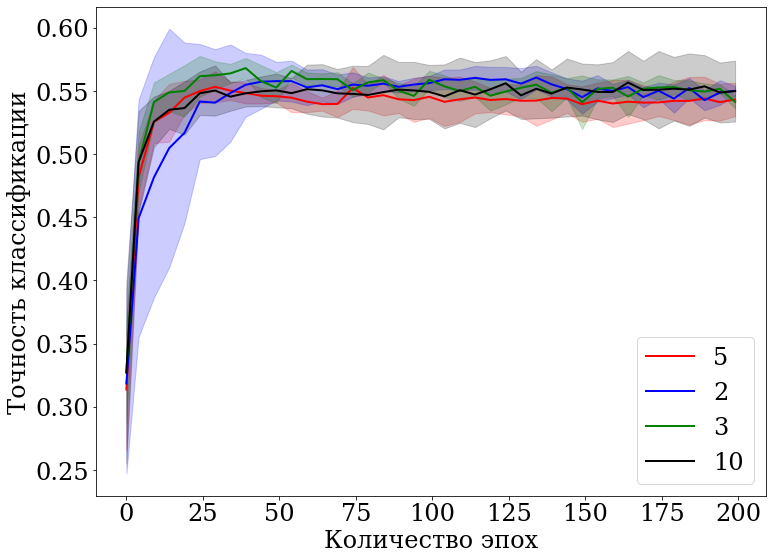

In [103]:
with open("exp11_dist_h_b2_optim.jsonl", "r") as read_file:
    data_5 = [json.loads(line) for line in read_file]
with open("exp12_dist_h_b2_optim.jsonl", "r") as read_file:
    data_2 = [json.loads(line) for line in read_file]
with open("exp13_dist_h_b2_optim.jsonl", "r") as read_file:
    data_3 = [json.loads(line) for line in read_file]
with open("exp14_dist_h_b2_optim.jsonl", "r") as read_file:
    data_10 = [json.loads(line) for line in read_file]

def plot_data(data, label, color):
    epoch = np.array([data[2]['results'][i]['epoch'] for i in range(len(data[2]['results']))])
    acc = np.array([subdata['results'][i]['accuracy'] for i in range(len(data[0]['results'])) for subdata in data]).reshape(epoch.shape[0], -1)
    plt.plot(epoch, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(epoch, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)
    
# epoch_2 = np.array([data_2[2]['results'][i]['epoch'] for i in range(len(data_2[2]['results']))])
# acc_2 = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_l[0]['results'])) for subdata in data_l]).reshape(epoch_l.shape[0], -1)
# plt.plot(epoch_l[0:11], acc_l[0:11].mean(1), '-', color='red', label='linear')
# plt.fill_between(epoch_l[0:11], acc_l[0:11].mean(1)-acc_l[0:11].std(1), acc_l[0:11].mean(1)+acc_l[0:11].std(1), alpha=0.2, color='red')

# epoch_q = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_q[2]['results']))])
# acc_q = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_q[0]['results'])) for subdata in data_q]).reshape(epoch_q.shape[0], -1)
# plt.plot(epoch_q, acc_q.mean(1), '-', color='blue', label='quadratic')
# plt.fill_between(epoch_q, acc_q.mean(1)-acc_q.std(1), acc_q.mean(1)+acc_q.std(1), alpha=0.2, color='blue')

# epoch_c = np.array([data_c[2]['results'][i]['epoch'] for i in range(len(data_c[2]['results']))])
# acc_c = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_c[0]['results'])) for subdata in data_c]).reshape(epoch_c.shape[0], -1)
# plt.plot(epoch_c, acc_c.mean(1), '-', color='green', label='cubic')
# plt.fill_between(epoch_c, acc_c.mean(1)-acc_c.std(1), acc_c.mean(1)+acc_c.std(1), alpha=0.2, color='green')
plot_data(data_5, '5', 'red')
plot_data(data_2, '2', 'blue')
plot_data(data_3, '3', 'green')
plot_data(data_10, '10', 'black')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc_splines.pdf')